In [35]:
'''
Læs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter

Næste gang:
'''



'\nLæs Gandhi + Houd instruments november 2020 (Behandling af instrumentvariable). Ellers gå med normale BLP instrumenter\n\nNæste gang:\n'

In [47]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt
import LinearModelsWeek3_post as lm


%reset -f
%load_ext autoreload
%autoreload 2

import functions as fun

from numpy import random
from scipy.stats import genextreme


## Data

In [48]:
df_overview = pd.read_excel('Overview.xlsx')
df_overview.sort_values(by=['Count'], ascending=True, inplace=True) 
df_overview.tail(5)
print(df_overview.columns)

df_overview = df_overview.rename(columns={'Chargetime': 'ChargeTime'})
df_overview = df_overview.rename(columns={'year': 'Year'})

unique_types = df_overview['Type'].unique()
for i in unique_types:
    df_overview[i] = np.where(df_overview['Type'] == i, 1, 0)


unique_Country = df_overview['Country'].unique()

unique_segments = df_overview['Segment'].unique()
for i in unique_segments:
    df_overview[i] = np.where(df_overview['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n Countrys : {unique_Country} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_overview['Europe'] = np.where((df_overview['Country'] != 'US') & (df_overview['Country'] != 'CH') & (df_overview['Country'] != 'JP') & (df_overview['Country'] != 'KR'), 1, 0)
df_overview['China'] = np.where(df_overview['Country'] == 'CH', 1, 0)
df_overview['USA'] = np.where(df_overview['Country'] == 'US', 1, 0)
df_overview['Other'] = np.where((df_overview['Europe'] != 1) & (df_overview['China'] != 1) & (df_overview['USA'] != 1), 1, 0)

df_overview.head(5)
#df_overview[df_overview['Manufacturer'] == 'Nissan']



NameError: name 'pd' is not defined

In [38]:
df_dataset = pd.read_csv('Dataset.csv')
df_dataset = df_dataset.rename(columns={'Chargetime': 'ChargeTime'})
unique_types = df_dataset['Type'].unique()
#print(df_dataset.columns)
for i in unique_types:
    df_dataset[i] = np.where(df_dataset['Type'] == i, 1, 0)


years = df_dataset['Year'].unique()

unique_Country = df_dataset['Country'].unique()

unique_segments = df_dataset['Segment'].unique()
for i in unique_segments:
    df_dataset[i] = np.where(df_dataset['Segment'] == i, 1, 0)


#Europa, Kina, USA, Andet
df_dataset['Europe'] = np.where((df_dataset['Country'] != 'US') & (df_dataset['Country'] != 'CH') & (df_dataset['Country'] != 'JP') & (df_dataset['Country'] != 'KR'), 1, 0)
df_dataset['China'] = np.where(df_dataset['Country'] == 'CH', 1, 0)
df_dataset['USA'] = np.where(df_dataset['Country'] == 'US', 1, 0)
df_dataset['Other'] = np.where((df_dataset['Europe'] != 1) & (df_dataset['China'] != 1) & (df_dataset['USA'] != 1), 1, 0)
print(df_dataset.head(1))


df_dataset_ms0 = df_dataset[df_dataset['Market share'] != 0]
df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)
#print(df_dataset_ms0.sample(1))

df_dataset_year_ms0 = {}
for year in years:
    df_dataset_year_ms0[year] = df_dataset_ms0[df_dataset_ms0['Year'] == year]




   ID  Year  Market share Manufacturer Model  Range  Price   HP  ChargeTime  \
0   1  2013           0.0       Aiways    U5    400    0.0  201          34   

  Type  ...  E  B  D  M  A  J  Europe  China  USA  Other  
0  SUV  ...  0  0  0  0  0  0       0      1    0      0  

[1 rows x 32 columns]


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_13440\1956551877.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)


In [39]:
df_dataset.head(11)
#df.info()

,ID,Year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,2013,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
1,1,2014,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
2,1,2015,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
3,1,2016,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
4,1,2017,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
5,1,2018,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
6,1,2019,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
7,1,2020,0.000000,Aiways,U5,400,0.000,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
8,1,2021,0.010373,Aiways,U5,400,284621.700,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
9,1,2022,0.005976,Aiways,U5,400,313681.829,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0


## Grafer

In [31]:
Country_shares = {
    'Europe': [],
    'China': [],
    'USA': [],
    'Other': []
}
#& (df_dataset['Market share'] != 0)
for Country in Country_shares.keys():
    for year in years:
        Country_df = df_dataset[(df_dataset[Country] == 1) & (df_dataset['year'] == year)]
        if not Country_df.empty:
            Country_shares[Country].append(Country_df['Market share'].sum())
#print(Country_shares)




KeyError: 'year'

ValueError: x and y must have same first dimension, but have shapes (11,) and (0,)

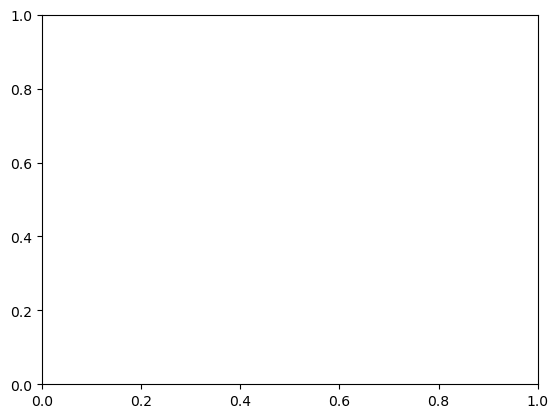

In [32]:
'''
Done
Hvem har størst market share? 
Pris mod market share
Pris/HP
Pris/Range
Hvordan ser det ud for kinesere isoleret?
Kinesere vs resten

Yet to come
Størst udvikling i market share?
'''

#Market share over time
#plt.figure(figsize=(12, 6))
for Country in Country_shares.keys():
    plt.plot(years, Country_shares[Country])
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()

#Pris mod market share
# x = pris, y = Count
#plt.scatter(x,y)
#Kun for de 5 med højest Count
mængde = 100
# Pris/Market Share
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Share[len(df_overview)-mængde:])
plt.title('Pris mod market share')
plt.xlabel('Pris(100k)')
plt.ylabel('Market Share')
plt.show()

# Pris/HP
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Pris/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

# Market share/HP
plt.scatter(df_overview.Share[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Market share/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

#Pris/Range
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Range[len(df_overview)-mængde:])
plt.title('Pris/Range')
plt.xlabel('Pris')
plt.ylabel('Range')
plt.show()

#Market share over time
plt.plot(years, Country_shares['China'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('China Cars Market Share over Time')
plt.show()

#Total Cars by Chinese Brand
df_china = df_overview[df_overview['China'] == 1]
brand_totals = df_china.groupby('Manufacturer')['Count'].sum()

plt.bar(brand_totals.index, brand_totals.values)
plt.title('Total Cars by Chinese Brand')
plt.xlabel('Manufacturer')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Kinesere by brands
df_china = df_overview[df_overview['China'] == 1]

total_kina = df_china['Count'].sum() #Alle kinesere (samlet)
plt.bar('Total Kina', total_kina)
plt.title('Total Cars by Chinese Brands')


#Alle ikke CH-brands mod total CH. 
df_not_china = df_overview[df_overview['China'] == 0]
not_china_totals = df_not_china.groupby('Manufacturer')['Count'].sum() #Alle ikke kinesere(unikke)
sorted_not_china_totals = not_china_totals.sort_values(ascending=False)

for i, (brand, total) in enumerate(sorted_not_china_totals.items()):
    plt.bar(brand, total, label=brand)

plt.title('Total Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Tesla models (Største i EU)
df_tesla = df_overview[df_overview['Manufacturer'] == 'Tesla']
df_tesla = df_tesla.groupby('Model')['Count'].sum()
plt.bar(df_tesla.index, df_tesla.values)
plt.title('Tesla Models')
plt.show()

#MG (største kinesiske mærke i DK)
df_mg = df_overview[df_overview['Manufacturer'] == 'MG']
df_mg = df_mg.groupby('Model')['Count'].sum()
plt.bar(df_mg.index, df_mg.values)
plt.title('MG Models')
plt.show()

#Cars by segment
segment_totals = df_overview.groupby('Segment')['Count'].sum()
plt.bar(segment_totals.index, segment_totals.values)
plt.title('Total Cars by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()




# Estimering

In [22]:
label_y = 'Market share'
label_x = ['Range', 'Price', 'HP', 'ChargeTime', 'China']
data_scaled = df_dataset
data_scaled['Range'] = data_scaled['Range'] / 100
data_scaled['Price'] = data_scaled['Price'] / 100000
data_scaled['HP'] = data_scaled['HP'] / 100
data_scaled['ChargeTime'] = data_scaled['ChargeTime'] / 100

## Standard OLS

In [19]:
#Bruger data hvor ms = 0 er inkluderet
data = df_dataset
N = data['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = data['Year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

AssertionError: Error: data is not a balanced panel

In [20]:
#Bruger data hvor ms = 0 er inkluderet
N
y = df_dataset['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df_dataset['Range'].values.reshape((N*T,1)) #1
Price = df_dataset['Price'].values.reshape((N*T,1)) #2
HP = df_dataset['HP'].values.reshape((N*T,1)) #3
ChargeTime = df_dataset['ChargeTime'].values.reshape((N*T,1))  #4
China = df_dataset['China'].values.reshape((N*T,1)) #5

X = np.hstack([ones, Range, Price, HP, ChargeTime, China])
#print(f' y \n {y[:2]} \n ones: \n {ones[:2]} \n X: {X[:2]} \n {X.size} \n')

ValueError: cannot reshape array of size 1197 into shape (1199,1)

In [21]:
#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


NameError: name 'y' is not defined

In [ ]:
#Bruger data hvor ms = 0 er ekskluderet
data = df_dataset_year_ms0[2023]

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


#OLS estimation
model = sm.OLS(y, X)
results = model.fit(cov_type='HC3')
print(results.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


Data has N=102 and T=1 data is = 102, 102
                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.916
Date:                Wed, 06 Mar 2024   Prob (F-statistic):             0.0171
Time:                        12:57:04   Log-Likelihood:                 217.42
No. Observations:                 102   AIC:                            -422.8
Df Residuals:                      96   BIC:                            -407.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const     

## Logit

In [34]:
#Estimere full sample med logit
data = df_dataset
N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

KeyError: 'year'

In [25]:
# Sample data generation

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


# Fit logistic regression model
#logit_model = sm.Logit(y, X)
#result = logit_model.fit(cov_type = 'HC3')

# Display results
#print(result.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))


ValueError: cannot reshape array of size 1197 into shape (1199,1)

## Conditional Logit

In [26]:

data = df_dataset
T = data['year'].unique().size
M = data['Model'].unique().size
#print(f'df {data.head(1)}, {data.shape}')

data = np.array(data[['Market share', 'Range', 'Price', 'HP', 'ChargeTime', 'China']])
#print(f'\n \n data: {data[:2]} \n shape {data.shape[1]}')
V = data.shape[1] - 1

y = data[:,0].reshape(M,1, T) #reshape for column vector
#print(f' \n \n y: {y[:2]} \n shape {y.shape}')

x = data[:,1:].reshape(M, V, T)
#print(f' \n \n x: {x[:2]} \n shape {x.shape}')

print(f' \n \n y shape {y.shape} \n \n x shape {x.shape}')

KeyError: 'year'

# BLP demand side

In [40]:

#Bruger data hvor ms = 0 er ekskluderet
data = df_dataset_year_ms0[2013]

#data format
xnames = ['Cons', 'Price', 'HP', 'ChargeTime']
N = data['ID'].unique().size
T = data['Year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')


#Declare variables
y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Price = data['Price'].values.reshape((N*T,1)) #1
HP = data['HP'].values.reshape((N*T,1)) #2
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #3
X = np.hstack([ones, Price, HP, ChargeTime])

#Estimate with OLS
results = fun.est_OLS(y, X, xnames)
#fun.logit(y, X, xnames)

Data has N=6 and T=1 data is = 6, 6
                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                 -1.226
Method:                 Least Squares   F-statistic:                   0.08220
Date:                Thu, 07 Mar 2024   Prob (F-statistic):              0.964
Time:                        14:47:48   Log-Likelihood:                 2.6013
No. Observations:                   6   AIC:                             2.797
Df Residuals:                       2   BIC:                             1.965
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Cons           0

c:\Users\Mikkel\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## $\textbf{Logit:}$ in market shares

In [41]:
coefficients = results.params
print(f'coefficients: {coefficients}')
coefficients_labels = xnames[1:]

model_labels = data['Model'].unique()
j = 0
for i in model_labels:
    j = j
    print(f'Car {j}: {i}')
    j = j+1  

#X skal være [i:i+1,2:] 2: for at fjerne consten og pris
#beta skal være [2:] for at fjerne konstant og pris-koefficienten og reshapes for at kunne lave matrixmultiplikaiton. 

alpha = coefficients[1]
beta = coefficients
p_j = data['Price'].values.reshape((N*T,1)) 

coefficients: [ 3.82950297e-02 -2.98586623e-07  5.69490295e-04  2.23793862e-03]
Car 0: Leaf
Car 1: Model S
Car 2: Zoe
Car 3: up!
Car 4: I3
Car 5: Fortwo


In [44]:
def exp_delta(alpha, beta, X, p_j):
    s_j = []
    exp_s_j = []
    for i in range(len(p_j)):
        s = alpha*p_j[i] + X[i:i+1,2:]@beta[2:].reshape(-1,1)
        s_j.append(s)
        
    for i in range (len(s_j)):
        exp_s_j.append(np.exp(s_j[i]))
    return exp_s_j

def ccp(alpha, beta, X, p_j):
    ccp_list = [] 
    exp_delta_list = exp_delta(alpha, beta, X, p_j)
    sum_exp = np.sum(exp_delta_list)
    
    for i in range(len(exp_delta_list)):
        ccp_list.append(exp_delta_list[i]/sum_exp) 
    print(f'choice probability sum: {np.sum(ccp_list)} \n 3 highest probability: {np.sort(ccp_list, axis=0)[-3:]}')
    return ccp_list

In [45]:
fun.ccp(alpha, beta, X, p_j)

choice probability sum: 1.0 
 3 highest probability: [[[0.16452744]]

 [[0.17003726]]

 [[0.18544787]]]


[array([[0.16243527]]),
 array([[0.18544787]]),
 array([[0.17003726]]),
 array([[0.16202464]]),
 array([[0.15552753]]),
 array([[0.16452744]])]

In [46]:
fun.logit(alpha, beta, X, p_j, model_labels, coefficients_labels, coefficients)

choice probability sum: 1.0 
 3 highest probability: [[[0.16452744]]

 [[0.17003726]]

 [[0.18544787]]]


In [ ]:
model_labels = data['Model'].unique()
j = 0
for i in model_labels:
    j = j
    print(f'Car {j}: {i}')
    j = j+1  
#exp_delta = fun.exp_delta(alpha, beta, X, p_jt)
CCP = fun.ccp(alpha, beta, X, p_j)
#prob = fun.probability_ratio(CCP, model_labels, model_labels)
#marg_effects = fun.marginal_effects(CCP, model_labels, coefficients_labels, coefficients)
#cross_marg_effects = cross_marginal_effects(CCP, model_labels, coefficients_labels, coefficients)
#ela = fun.elasticity(CCP, model_labels, coefficients_labels, beta, X) #Egen pris-elasticitet
#cross_elasticity = fun.cross_elasticity(CCP, beta, X, model_labels)
#print_cross_elasticity(cross_elasticity, model_labels)


Car 0: Leaf
Car 1: Model S
Car 2: Zoe
Car 3: up!
Car 4: Fortwo
Car 5: I3
choice probability sum: 0.9999999999999999 
 5 highest probability: [[0.18228852]
 [0.16951967]
 [0.16280674]
 [0.16490926]
 [0.15732376]] 
 5 lowest probability: [[0.16315206]
 [0.18228852]
 [0.16951967]
 [0.16280674]
 [0.16490926]]


$log(s_{jt})$ = $\alpha p_{jt} + x_{jt}\beta + \xi_{jt}$

Udregner for alle j 
$
:Pr(j|t)\frac{exp(\delta_{jt})}{\sum_{k \in J_t} exp(\delta_{kt})}
$

### Logit probability ratio : $ \frac{P_i}{P_k} = \frac{e^V_{i}/ \sum_j e^V_j}{e^V_{k}/ \sum_j e^V_j} = \frac{e^V_i}{e^V_k} = e^{V_i-V_k} $ \\
Hvor meget større ssh der er for at vælge produkt i fremfor produkt k. Kun produkt i og k er inkluderet og modellen udstiller derfor \\ $\textit{independance of irrelevant alternatives}$ . Rød bus blå bus eksempel s. 14/51 i kapitel 3

### Marginal effetcs for produkt i: $\frac{dP_{i}}{dz_i} = \frac{dV_i}{dz_i} P_i(1-P_i)$

### Antager $z_i$ er lineær giver = $\frac{dV_i}{dz_i} = \beta_i$

### Ændring i attibute for i på alternativ j: $-\frac{dV_j}{dz_j}P_iP_j$ \\
Antager stadig $z_i$ er lineær giver = $\frac{dV_i}{dz_i} = \beta_i$

### Elasticity: En ændring i en variabel ved en ændring på 1 pct ved en anden: $ E_{iz_i} = \frac{dP_i}{dz_i}\frac{z_i}{P_i}  = \frac{dV_i}{dz_i}z_i(1-P_i)$


### Cross Elasticity: $ E_{iz_i} = \frac{dP_i}{dz_j}\frac{z_j}{P_i} = -\frac{dV_j}{dz_j}z_jP_j$
